# cityB SVR

#### 設定

In [2]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

fatal: destination path 'geobleu' already exists and is not an empty directory.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.3-py3-none-any.whl size=5037 sha256=cf85a553b95a2c8e664059a7fde96b2472473705b6765e55123a1fe54ff49719
  Stored in directory: /tmp/pip-ephem-wheel-cache-19uhy22g/wheels/15/98/c8/330b8225e74188a134268a5ac7b536896fe9cc4650bc728bc9
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [3]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
INPUT_PATH = "../../s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz"
# INPUT_PATH = "/kaggle/input/humob2024/cityB_challengedata.csv/hiroshima_challengedata.csv"

#### データ読み込み

In [5]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head(3)

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102


#### ユーザーを絞り込み、d=60前後で訓練データと正解データに分割

In [6]:
# uidが20000~21999のデータを検証に利用
df_city_b_valid = (
    df_city_b
    .loc[df_city_b["uid"].between(20000, 21999)]
    # .loc[df_city_b["uid"].between(20000, 20010)]

)
df_city_b_valid.head(3)

,uid,d,t,x,y
20253615,20000,0,0,79,89
20253616,20000,0,2,79,89
20253617,20000,0,5,79,89


In [7]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] < 60]
)

df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] >= 60]
)

In [8]:
## あとで学習データの補完もしてみる

### 特徴量の作成

In [9]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [10]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [11]:
def attach_feature_day_of_week(df):
    # d = 0が2020/1/5に対応
    df["date"]  = pd.to_datetime("2020-01-05") + pd.to_timedelta(df["d"],unit="D")
    
    # 曜日 0:Mon,... 5:Sat,6:Sun
    df["dow"] = df["date"].dt.weekday
    
    return df.drop(columns = ["date"])

In [12]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [13]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [14]:
def attach_features(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df)
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 
    return df

In [15]:
# 学習データに特徴量付与
df_city_b_train = attach_features(df_city_b_train)
df_city_b_train.head(2)

/tmp/ipykernel_244067/2592063384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
/tmp/ipykernel_244067/2592063384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
/tmp/ipykernel_244067/2592063384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,dow,weekdays,AM
20253615,20000,0,0,79,89,0.0,1.0,0.0,1.000000,0,0,0,1,6,0,1
20253616,20000,0,2,79,89,0.0,1.0,0.5,0.866025,0,0,0,1,6,0,1


### 学習

In [16]:
# ユーザーごと（uidごと）にデータを分けてモデルを作成

# 学習データがあるuidのみに絞り込む <- データが無い人はどうする？
uids = df_city_b_train['uid'].unique()

# 各uidごとにモデルを作成し、結果を格納する辞書
models = {}
future_predictions = []

for uid in tqdm(uids,desc="Processing uids"):
    # 該当uidのデータを抽出
    user_data = df_city_b_train[df_city_b_train['uid'] == uid]
    # 学習に必要ないカラムは除去
    user_data_train = user_data.drop(columns=["uid","d","t","x","y"])

    #目的変数の設定
    y_train_x = user_data['x']
    y_train_y = user_data['y']

    # データの標準化
    scaler = StandardScaler()
    user_data_train_scaled = scaler.fit_transform(user_data_train)

    # SVR モデルの作成と学習 (xとyそれぞれのモデル)
    svr_x = SVR(kernel='rbf')
    svr_x.fit(user_data_train_scaled, y_train_x)

    svr_y = SVR(kernel='rbf')
    svr_y.fit(user_data_train_scaled, y_train_y) 

    # モデルの保存
    models[(uid, 'x')] = svr_x
    models[(uid, 'y')] = svr_y

    # 未来の予測
    # 予測期間の設定 (d=60からd=74まで)
    d_range = np.arange(60, 75)  # 60～74のd値
    time_range = np.arange(0, 48)  # t=0～47の範囲 (30分ごと)

    # d と t の組み合わせを生成
    future_dates = pd.DataFrame([(d, t) for d in d_range for t in time_range], columns=['d', 't'])
    
    # dとtだけで決まる特徴量を作成し、標準化
    future_dates_featured = attach_features(future_dates)
    future_dates_featured = future_dates_featured.drop(columns=["d","t"])
    future_df_scaled = scaler.transform(future_dates_featured)

    #学習したモデルで未来予測
    y_pred_x = svr_x.predict(future_df_scaled)
    y_pred_y = svr_y.predict(future_df_scaled)
    
    
    # 予測データを整形
    future_dates['uid'] = uid
    future_dates['x'] = y_pred_x
    future_dates['y'] = y_pred_y
    future_predictions.append(future_dates)


# uidをすべて結合
future_predictions_df = pd.concat(future_predictions, ignore_index=True)
future_predictions_df["x"] = future_predictions_df["x"].round(0)
future_predictions_df["y"] = future_predictions_df["y"].round(0)



Processing uids: 100%|██████████| 2000/2000 [01:44<00:00, 19.06it/s]


In [17]:
future_predictions_df.head(2)

,d,t,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,date,dow,uid,x,y
0,60,0,-0.433884,-0.900969,0.000000,1.000000,0,0,0,1,2020-03-05,3,20000,79.0,89.0
1,60,1,-0.433884,-0.900969,0.258819,0.965926,0,0,0,1,2020-03-05,3,20000,79.0,89.0


In [18]:
### 正解データと予測データの組み合わせ
combined_data = (
    pd.merge(
        df_city_b_answer,
        future_predictions_df.rename(columns = {"x":"x_pred","y":"y_pred"}),
        on = ["uid","d","t"],
        # ここで正解データ基準で結合してよいか？正解データ自体の欠損はどうする？
        how = "left"
    )
)[["uid","d","t","x","y","x_pred","y_pred"]]


In [19]:
combined_data.head(2)

,uid,d,t,x,y,x_pred,y_pred
0,20000,60,11,79,89,79.0,89.0
1,20000,60,15,79,89,79.0,89.0


In [25]:
list_geobleu_val = []
list_dtw_val = []

for i in tqdm(range(20000, 22000),desc="Processing uids"):
    
    # 該当uidのデータを抽出
    df = (
        combined_data
        .loc[combined_data["uid"] == i]
    )

    # 予測値のリスト
    df_pred = df[["d", "t", "x_pred", "y_pred"]]
    list_pred = [tuple(row) for row in df_pred.to_records(index=False)]

    # 正解値のリスト
    df_answer = df[["d", "t", "x", "y"]]
    list_answer = [tuple(row) for row in df_answer.to_records(index=False)]

    # if (len(list_pred) > 0) and (len(list_answer) > 0) :
    #     # スコア算出
    #     geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    #     list_geobleu_val.append(geobleu_val)
        
    #     dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    #     list_dtw_val.append(dtw_val)

    # スコア算出
    geobleu_val = geobleu.calc_geobleu(list_pred, list_answer, processes=3)
    list_geobleu_val.append(geobleu_val)
    
    dtw_val = geobleu.calc_dtw(list_pred, list_answer, processes=3)
    list_dtw_val.append(dtw_val)


Processing uids: 100%|██████████| 2000/2000 [05:03<00:00,  6.60it/s]


In [27]:
print(f"geobleu:{np.mean(list_geobleu_val)}")
print(f"dtw:{np.mean(list_dtw_val)}")

geobleu:0.22851323220529116
dtw:24.66036645689211


(array([309., 262., 229., 228., 159., 169., 151., 116., 111.,  71.,  64.,
         52.,  34.,  21.,  11.,   7.,   1.,   1.,   0.,   4.]),
 array([3.21550210e-15, 4.89122651e-02, 9.78245302e-02, 1.46736795e-01,
        1.95649060e-01, 2.44561325e-01, 2.93473590e-01, 3.42385856e-01,
        3.91298121e-01, 4.40210386e-01, 4.89122651e-01, 5.38034916e-01,
        5.86947181e-01, 6.35859446e-01, 6.84771711e-01, 7.33683976e-01,
        7.82596241e-01, 8.31508506e-01, 8.80420771e-01, 9.29333037e-01,
        9.78245302e-01]),
 <BarContainer object of 20 artists>)

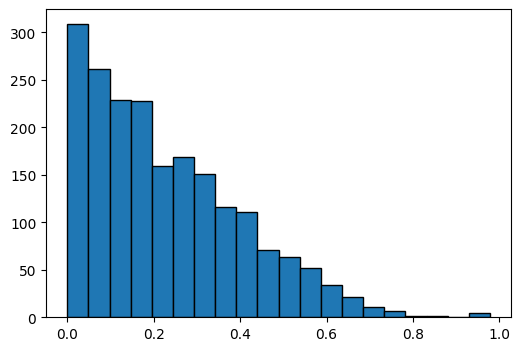

In [30]:
plt.figure(figsize=(6, 4))
plt.hist(list_geobleu_val, bins=20, edgecolor='black')

(array([1.193e+03, 4.430e+02, 1.810e+02, 8.500e+01, 3.700e+01, 2.600e+01,
        1.100e+01, 9.000e+00, 7.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.        ,  19.5194846 ,  39.0389692 ,  58.55845379,
         78.07793839,  97.59742299, 117.11690759, 136.63639218,
        156.15587678, 175.67536138, 195.19484598, 214.71433058,
        234.23381517, 253.75329977, 273.27278437, 292.79226897,
        312.31175357, 331.83123816, 351.35072276, 370.87020736,
        390.38969196]),
 <BarContainer object of 20 artists>)

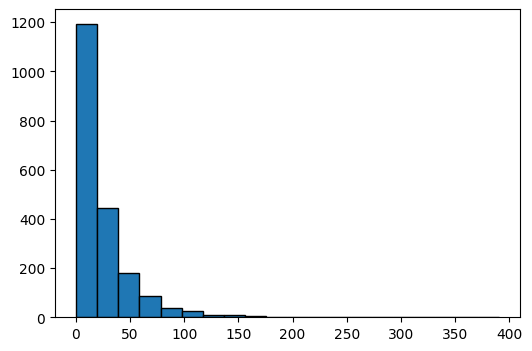

In [31]:
plt.figure(figsize=(6, 4))
plt.hist(list_dtw_val, bins=20, edgecolor='black')

## 可視化して確認

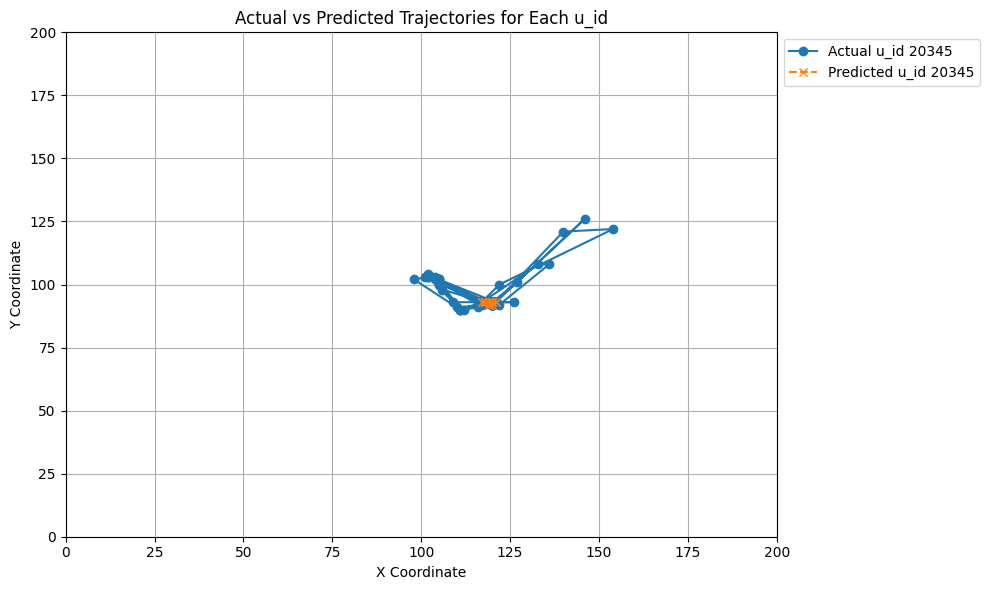

In [24]:
# 特定のuidを見る場合
plt.figure(figsize=(10, 6))

uid = 20345
user_data = combined_data[combined_data['uid'] == uid]

# 実際の軌跡をプロット（実線と丸マーカー）
plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}')

# 予測された軌跡をプロット（点線と×マーカー）
plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.xlim(0, 200)  # x軸の範囲を設定
plt.ylim(0, 200)  # y軸の範囲を設定

# プロットを表示
plt.tight_layout()
plt.show()

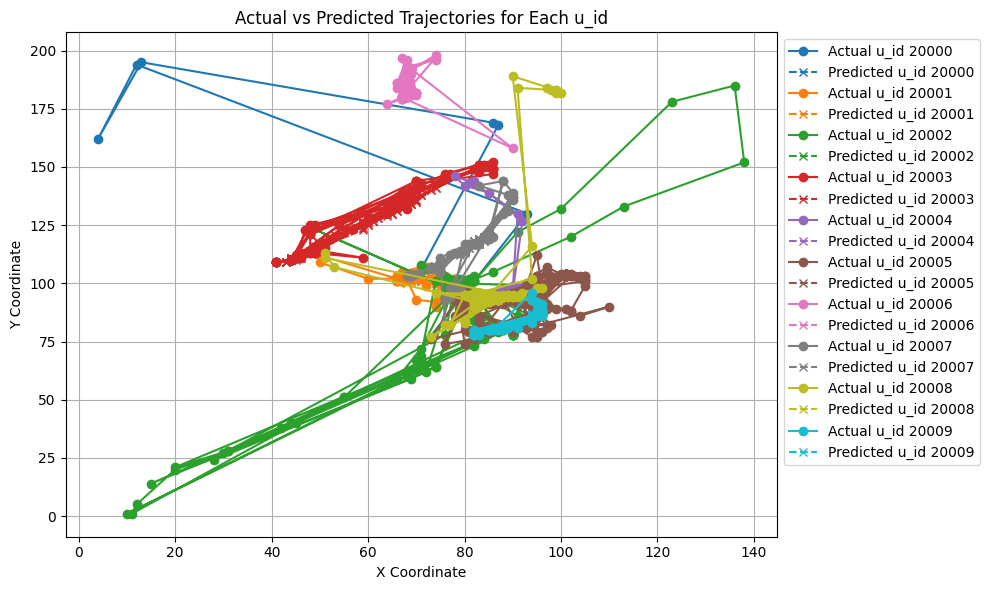

In [249]:
# まとめて何人か見る場合
plt.figure(figsize=(10, 6))

for uid in range(20000, 20010):

    user_data = combined_data[combined_data['uid'] == uid]
    
    # 実際の軌跡をプロット（実線と丸マーカー）
    plt.plot(user_data['x'], user_data['y'], marker='o', label=f'Actual u_id {uid}', color=f'C{uid}')
    
    # 予測された軌跡をプロット（点線と×マーカー）
    plt.plot(user_data['x_pred'], user_data['y_pred'], marker='x', linestyle='--', label=f'Predicted u_id {uid}', color=f'C{uid}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Trajectories for Each u_id')

# 凡例をグラフの外に配置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# プロットを表示
plt.tight_layout()
plt.show()